In [1]:
import deepdish.io as io
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [5]:
d = h5py.File('../data/electrons-10GeV-incidence-perp.hdf5', 'r')

In [6]:
matplotlib.__version__ # should be 2.0.0

'2.0.0'

In [7]:
first = d['layer_0'][:]
second = d['layer_1'][:]
third = d['layer_2'][:]

In [8]:
sizes = [first.shape[1], first.shape[2], second.shape[1], second.shape[2], third.shape[1], third.shape[2]]

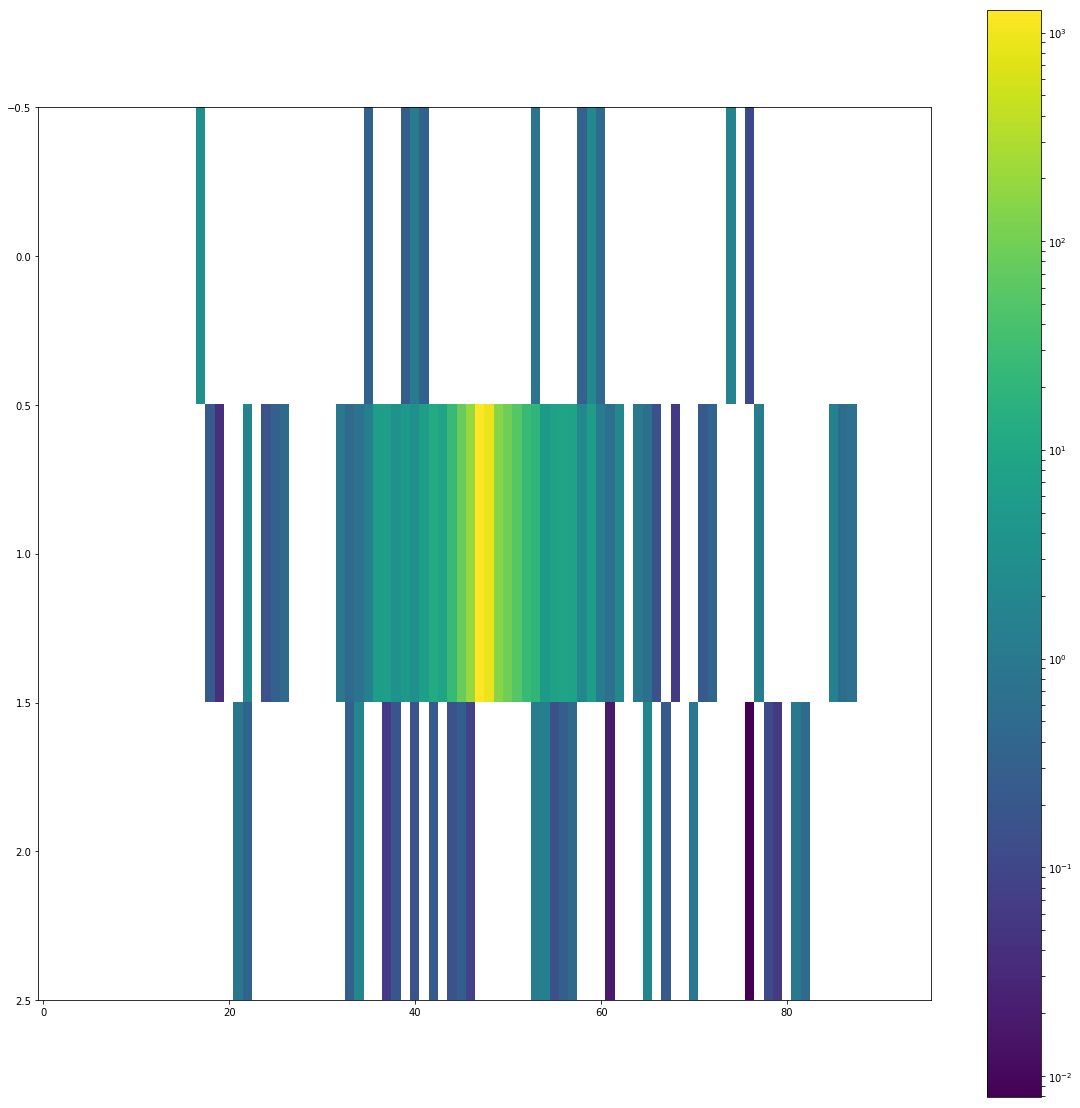

In [6]:
imageix = 0
plt.figure(figsize=(20,20))
plt.imshow(first[imageix], aspect=float(first.shape[2])/first.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()
# aspect is needed to make this 3*96 image come out nice

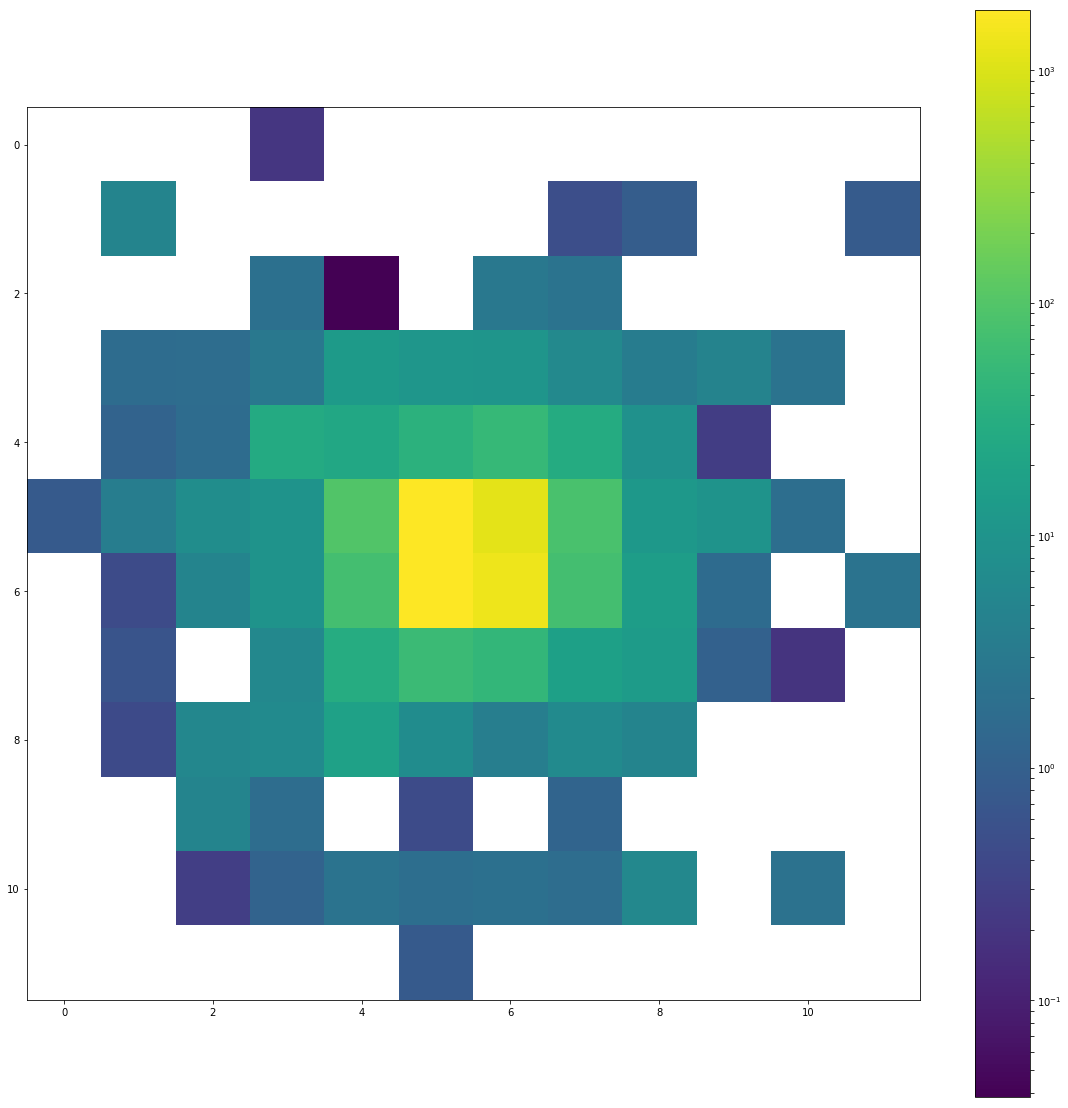

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(second[imageix], aspect=float(second.shape[2])/second.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()

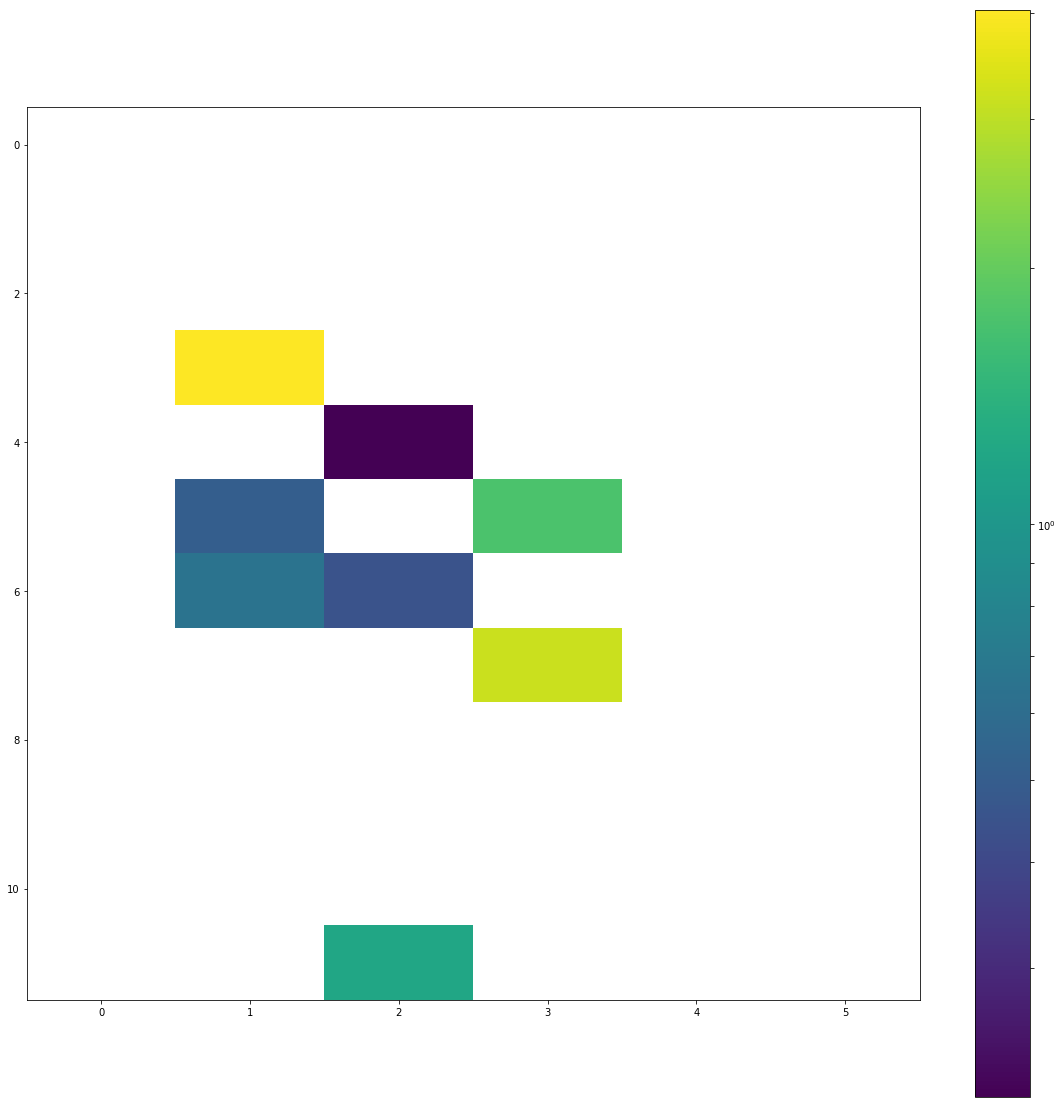

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(third[imageix], aspect=float(third.shape[2])/third.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()

In [3]:
import keras.backend as K
from keras.layers import (Input, Dense, Reshape, Flatten, Lambda, merge,
                          Dropout, BatchNormalization, Embedding, Activation)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import (UpSampling2D, Conv2D, ZeroPadding2D,
                                        AveragePooling2D)
from keras.layers.local import LocallyConnected2D
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model
from keras.optimizers import Adam

K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [11]:
nb_classes = 2

In [12]:
discr_inputs = [Input(shape=sizes[:2] + [1]), Input(shape=sizes[2:4] + [1]), Input(shape=sizes[4:] + [1])]
#discr_inputs_middle = [Input(shape=sizes[:2] + [1]), Input(shape=sizes[2:4] + [1]), Input(shape=sizes[4:] + [1])]
features = []
# for image, image_middle in zip(discr_inputs, discr_inputs_middle):
for image in discr_inputs:
    x = Conv2D(32, (2, 2), padding='same')(image)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    # block 2: 'same' bordered 3x3 locally connected block with batchnorm and
    # 2x2 subsampling
    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (3, 3), padding='valid', strides=(1, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # block 2: 'same' bordered 5x5 locally connected block with batchnorm
    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # block 3: 2x2 locally connected block with batchnorm and
    # 1x2 subsampling
    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid', strides=(1, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    h = Flatten()(x)

    dnn = Model(inputs=image, outputs=h)
    #evt_image = Input(shape=[int(a) for a in image.shape[1:]])#(img_shape[0], img_shape[1], 1))
    out = dnn(image)
    # out = dnn.outputs[0]
    #out = h 

    # nb of features to obtain
    nb_features = 20
    # dim of kernel space
    vspace_dim = 10

    # creates the kernel space for the minibatch discrimination
#        K_x = Dense3D(nb_features, vspace_dim)(out)#(h)#(out)

#        minibatch_featurizer = Lambda(minibatch_discriminator,
#                                  output_shape=minibatch_output_shape)

    features.append(out)
    # concat the minibatch features with the normal ones
#        features.append( 
#            merge(
#                [
#                    minibatch_featurizer(K_x),
#                    out #h
#                ],
#                mode='concat'
#            )
#        )

p =  LeakyReLU()(
        Dense(64)(
            LeakyReLU()(
                Dense(128)(
                    merge(features, mode='concat')))))

fake = Dense(1, activation='sigmoid', name='fakereal_output')(p)
aux = Dense(1, activation='sigmoid', name='auxiliary_output')(p)

discriminator = Model(
    inputs=discr_inputs,
    outputs=[fake, aux])

if nb_classes == 2:
    aux_loss = 'binary_crossentropy'
else:
    aux_loss = 'sparse_categorical_crossentropy'

discriminator.compile(
    optimizer=Adam(lr=0.0002, beta_1=0.5),
    loss={
        'fakereal_output' : 'binary_crossentropy',
        'auxiliary_output' : aux_loss
    }
)

plot_model(discriminator,
           to_file='discriminator.png',
           show_shapes=True,
           show_layer_names=True)

/Users/mp744/Documents/CERN/external_dl_work/caloGAN/gan/lib/python2.7/site-packages/ipykernel/__main__.py:64: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [13]:
first /=(500)
second /=(500)
third/=(500)

In [24]:
# plot_model(discriminator,
#            to_file='discriminator.png',
#            show_shapes=True,
#            show_layer_names=True)

In [26]:
# !open discriminator.png

In [189]:
discriminator.load_weights('../weights/acgan/params_discriminator_epoch_046.hdf5')

In [93]:
yhat_real_electrons = discriminator.predict([
    np.expand_dims(first[:], -1),
    np.expand_dims(second[:], -1),
    np.expand_dims(third[:], -1)],
      verbose=True,
      batch_size=200)

100000/100000 [==============================] - 155s     

In [18]:
latent_size = 500
latent = Input(shape=(latent_size, ), name='z')

def _pairwise(iterable):
    from itertools import izip
    '''s -> (s0, s1), (s2, s3), (s4, s5), ...'''
    a = iter(iterable)
    return izip(a, a)

outputs = []
# this will be our label
image_class = Input(shape=(1, ), dtype='int32')
emb = Flatten()(Embedding(nb_classes, latent_size, input_length=1,
                          embeddings_initializer='glorot_normal')(image_class))
# hadamard product between z-space and a class conditional embedding
h = merge([latent, emb], mode='mul')

for img_shape in _pairwise(sizes):
    x = Dense((img_shape[0] + 2) * (img_shape[1] + 2) * 12)(h)
    x = Reshape((img_shape[0] + 2, img_shape[1] + 2, 12))(x)
    # block 1: (None, 5, 98, 12) => (None, 5, 98, 8),
    x = Conv2D(8, (2, 2), padding='same', kernel_initializer='he_uniform')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    # block 2: (None, 5, 98, 32) => (None, 4, 97, 6),
    #ZeroPadding2D((2, 2)),
    x = LocallyConnected2D(6, (2, 2), kernel_initializer='he_uniform')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    # block 3: (None, 4, 97, 6) => (None, 3, 96, 1),
    x = LocallyConnected2D(1, (2, 2), use_bias=False, kernel_initializer='glorot_normal')(x)
    y = Activation('relu')(x)
    outputs.append(y)

generator = Model(inputs=[latent, image_class], outputs=outputs)
generator.compile(
    optimizer=Adam(lr=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)
plot_model(generator,
           to_file='generator.png',
           show_shapes=True,
           show_layer_names=True)

# load in previous training
#generator.load_weights('./params_generator_epoch_099.hdf5')

/Users/mp744/Documents/CERN/external_dl_work/caloGAN/gan/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [224]:
noise = np.random.normal(0, 1, (20000, latent_size))
sampled_labels = np.random.randint(0, nb_classes, 20000)

In [179]:
generator.load_weights('../weights/acgan/params_generator_epoch_046.hdf5')

In [21]:
!open *.png

In [225]:
gen_images = generator.predict([noise, sampled_labels], verbose=True)

20000/20000 [==============================] - 31s     

In [226]:
real_images = [first, second, third]

In [227]:
vmin = [first.mean(axis=0).min(), second.mean(axis=0).min(), third.mean(axis=0).min()]
vmax = [first.mean(axis=0).max(), second.mean(axis=0).max(), third.mean(axis=0).max()]

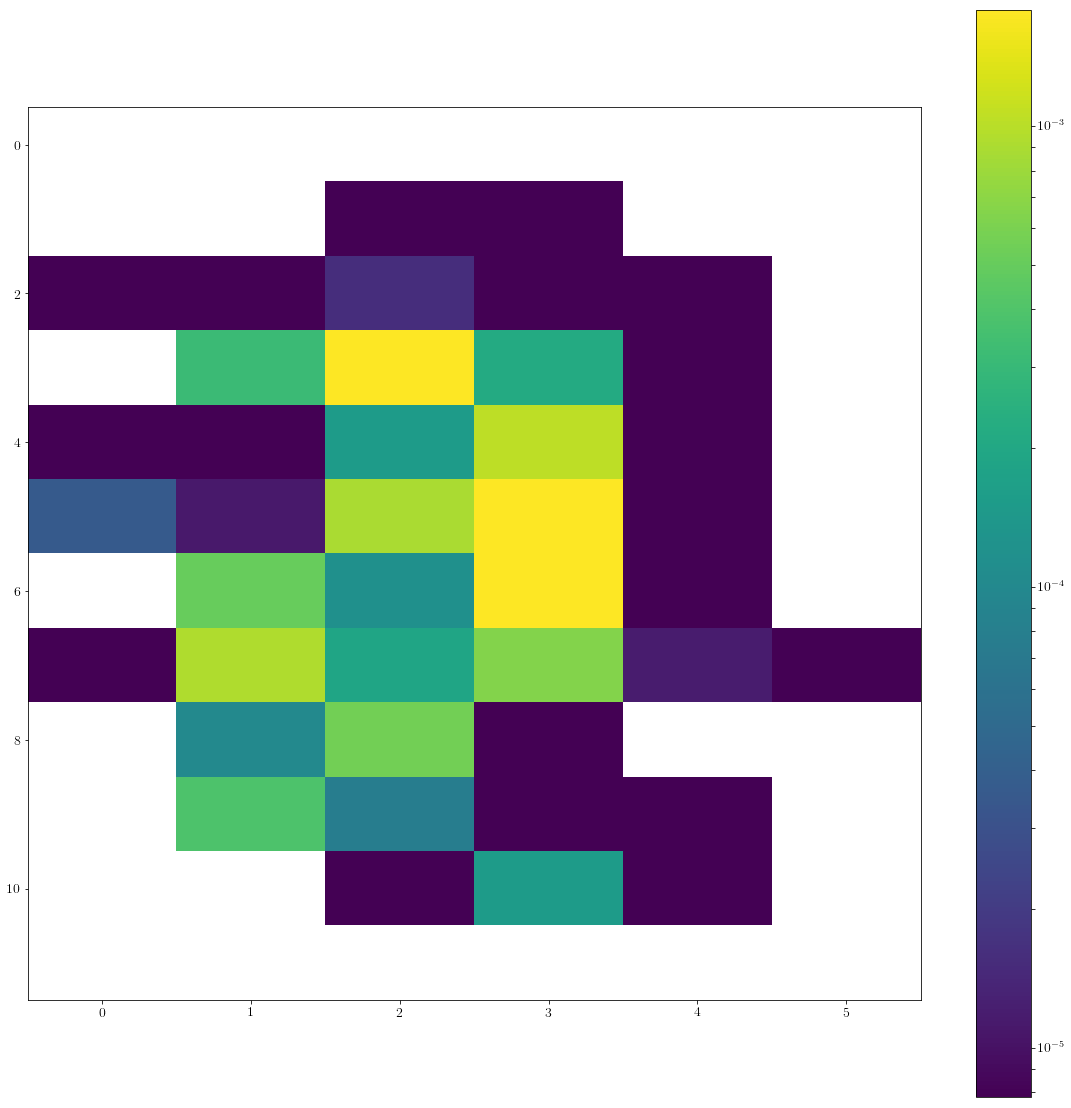

In [228]:
i = 2
plt.figure(figsize=(20,20))
matplotlib.rcParams.update({'font.size': 40})
plt.imshow(np.squeeze(gen_images[i]).mean(axis=0), interpolation='nearest',
           aspect=sizes[1+(i*2)] / float(sizes[(0)+(i*2)]),
           norm=LogNorm(vmin=vmin[i], vmax=vmax[i]))
plt.colorbar()

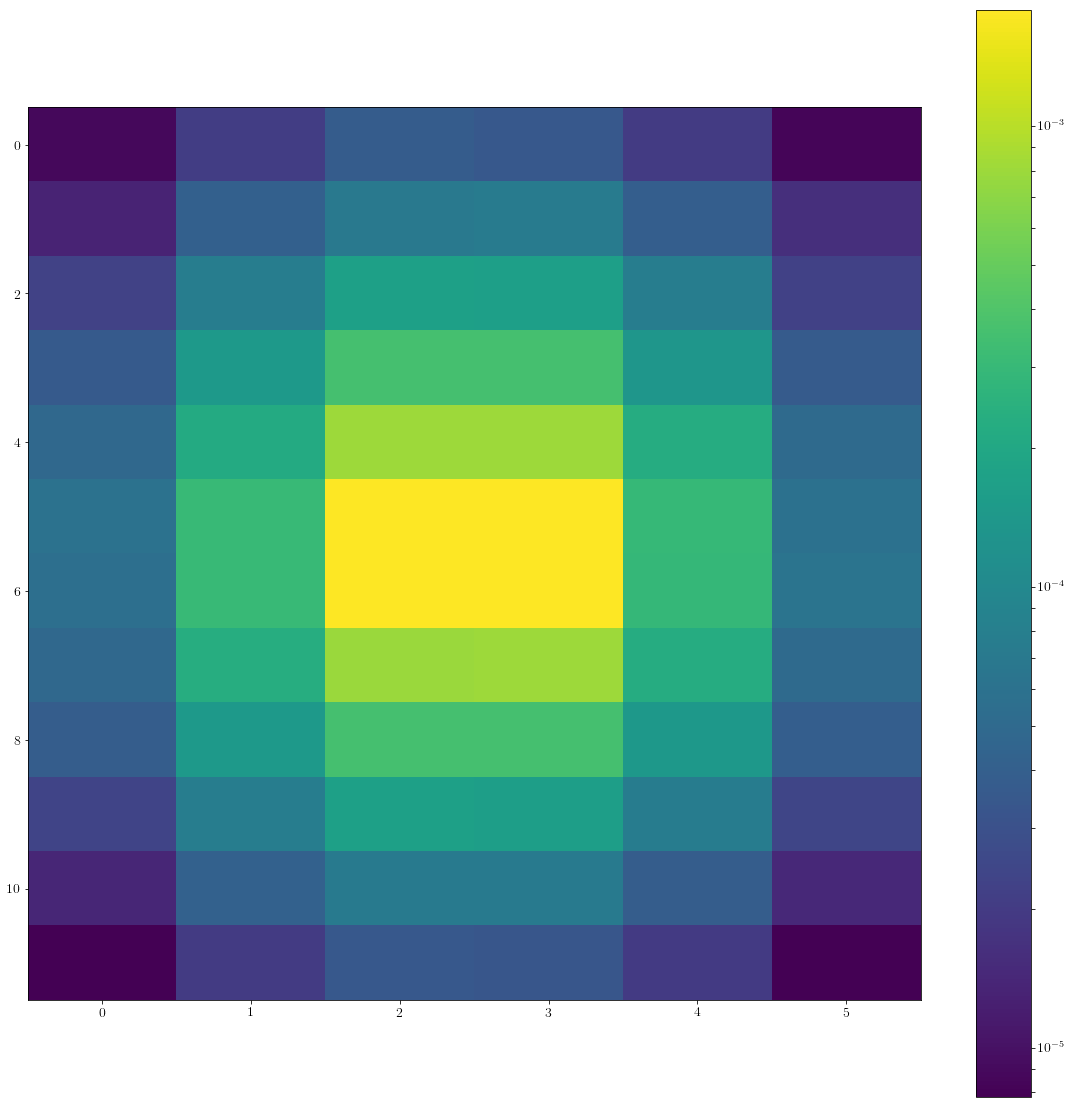

In [223]:
plt.figure(figsize=(20,20))
im = plt.imshow(real_images[i].mean(axis=0), interpolation='nearest',
           aspect=sizes[1+(i*2)] / float(sizes[(0)+(i*2)]),
           norm=LogNorm())
plt.colorbar()

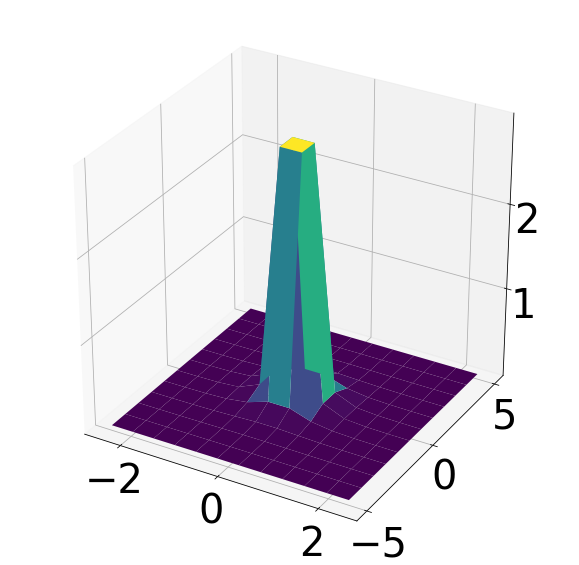

In [44]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-2.4, 2.4, 12)
y = np.linspace(-5, 5, 12)
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, second.mean(axis=0), cmap=cm.viridis)

In [50]:
import ndap
reload(ndap)

<module 'ndap' from 'ndap.pyc'>

In [51]:
import matplotlib

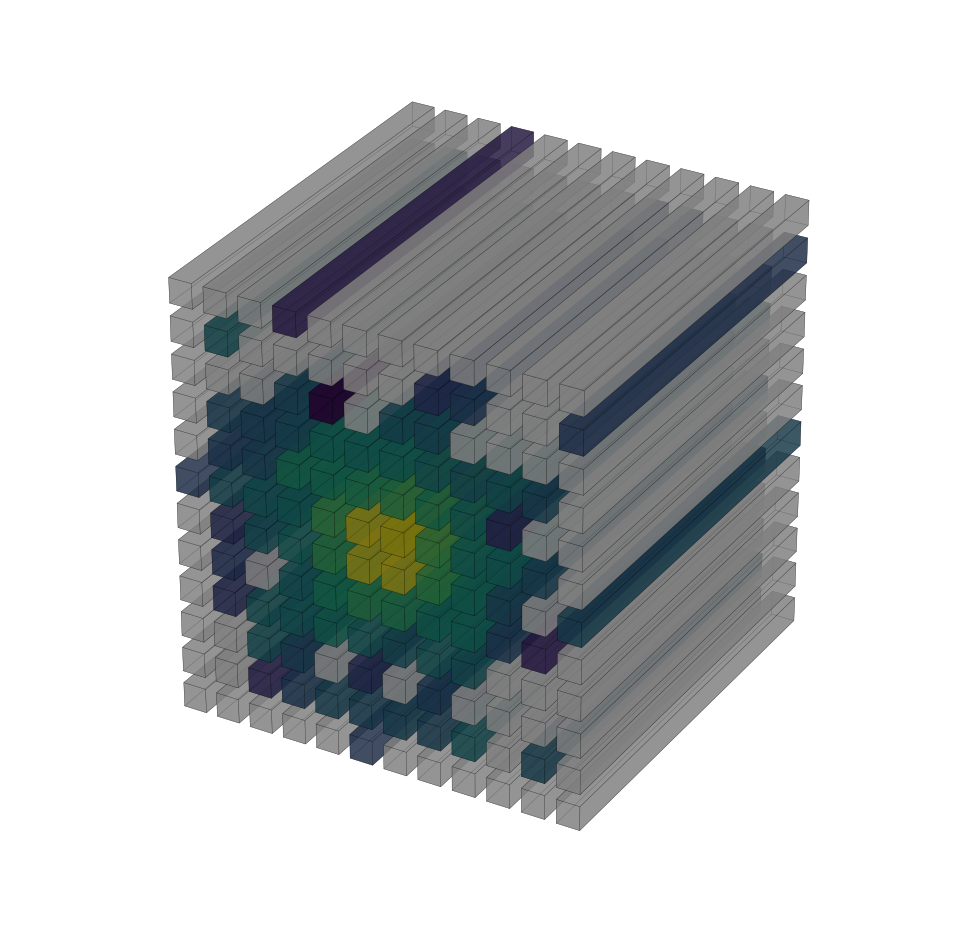

In [26]:
color = im.cmap(im.norm(second[0]))#.mean(axis=0)))
img_size = (12, 12)
depth = 1
subject = np.ones((depth, ) + img_size)
# image settings
plotter = ndap.NDArrayPlotter(subject, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 2, 0.5, 0.5), # inter-cube spacing
                              scale=(1, 1, 1)) # relative lengths
# colors 
colors = np.array(
    [matplotlib.colors.to_hex(c) for c in color.reshape(img_size[0] * img_size[1], 4)]
).reshape((1, ) + img_size)
colors[colors == '#000000'] = '#ffffff'
colors = np.tile(colors, (depth, 1, 1))
plotter.set_color(colors)

i = 1
(fig, ax) = plotter.render(azim=30, elev=30)
#plt.savefig('1.png', transparent=True)

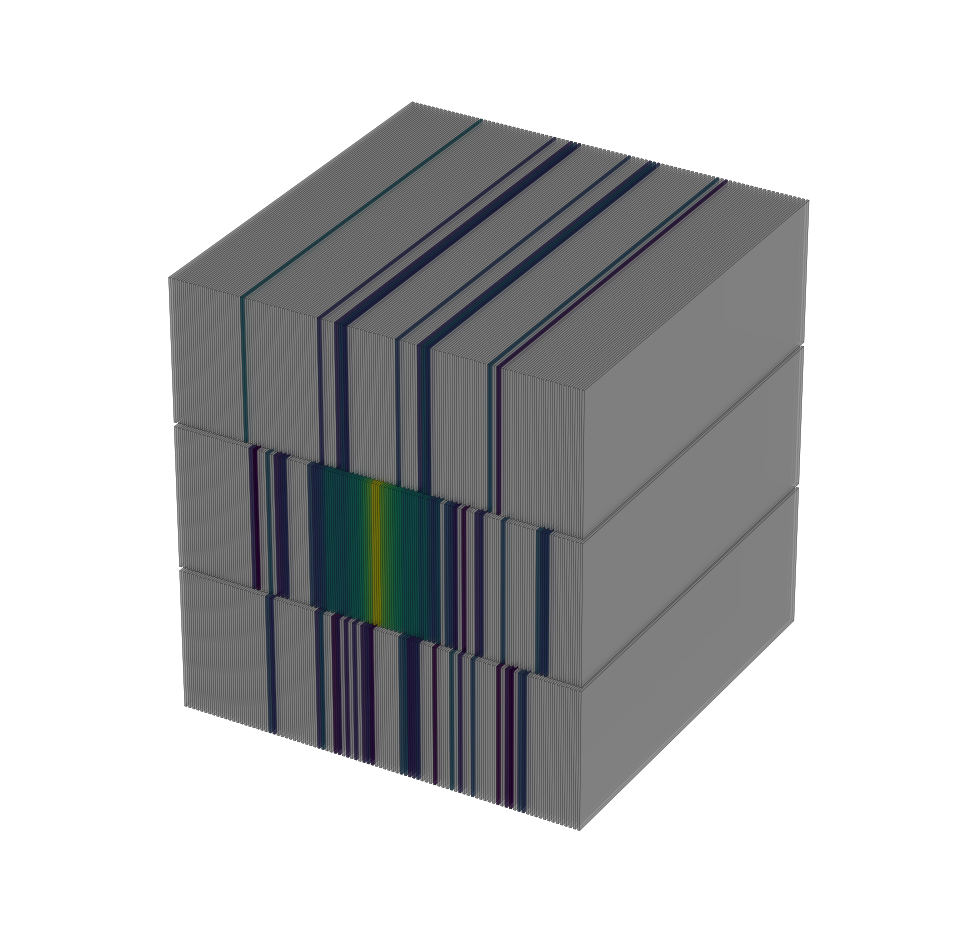

In [20]:
color = im.cmap(im.norm(first[0]))#.mean(axis=0)))
img_size = (3, 96)
depth = 1
subject = np.ones((depth, ) + img_size)
# image settings
plotter = ndap.NDArrayPlotter(subject, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 5, 1, 1), # inter-cube spacing
                              scale=(4.3, 96/3, 1)) # relative lengths
# colors 
colors = np.array(
    [matplotlib.colors.to_hex(c) for c in color.reshape(img_size[0] * img_size[1], 4)]
).reshape((1, ) + img_size)
colors[colors == '#000000'] = '#ffffff'
colors = np.tile(colors, (depth, 1, 1))
plotter.set_color(colors)

i = 1
(fig, ax) = plotter.render(azim=30, elev=30)
plt.savefig('0.png', transparent=True)

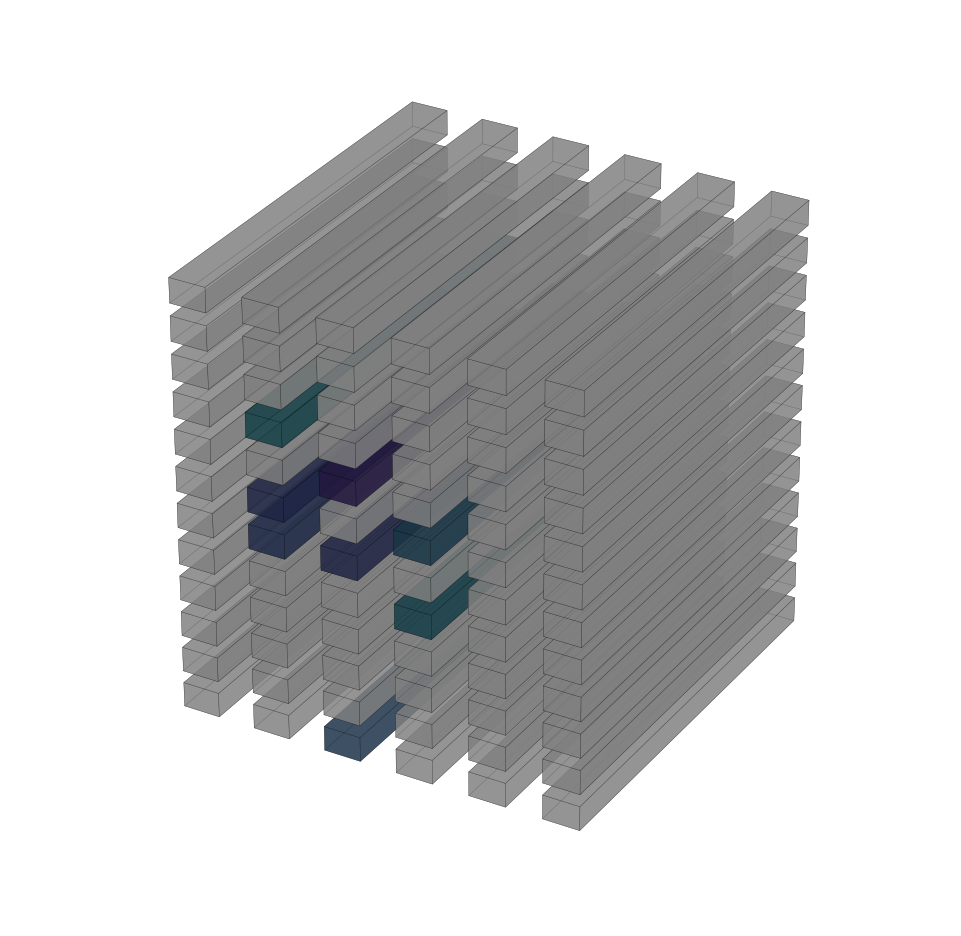

In [150]:
color = im.cmap(im.norm(third[0]))#.mean(axis=0)))
img_size = (12, 6)
depth = 1
subject = np.ones((depth, ) + img_size)
# image settings
plotter = ndap.NDArrayPlotter(subject, # default grid
                              alpha=0.6, # opacity
                              spacing=("even", 1, 1, 1), # inter-cube spacing
                              scale=(2, 12/6, 1)) # relative lengths
# colors 
colors = np.array(
    [matplotlib.colors.to_hex(c) for c in color.reshape(img_size[0] * img_size[1], 4)]
).reshape((1, ) + img_size)
colors[colors == '#000000'] = '#ffffff'
colors = np.tile(colors, (depth, 1, 1))
plotter.set_color(colors)

i = 1
(fig, ax) = plotter.render(azim=30, elev=30)
plt.savefig('2.png', transparent=True)

In [69]:
yhat_fake = discriminator.predict(
      gen_images,
      verbose=True,
      batch_size=200)

1000/1000 [==============================] - 73s     


In [21]:
gen_images[0].shape

(10000, 3, 96, 1)

In [190]:
from feats1d import *

In [191]:
dgen = {
    'layer_0' : np.squeeze(gen_images[0]) * 500,
    'layer_1' : np.squeeze(gen_images[1]) * 500,
    'layer_2' : np.squeeze(gen_images[2]) * 500
}

In [192]:
matplotlib.rcParams.update({'font.size': 40})

In [193]:
depth_orig = depth(d)
depth_gen = depth(dgen)

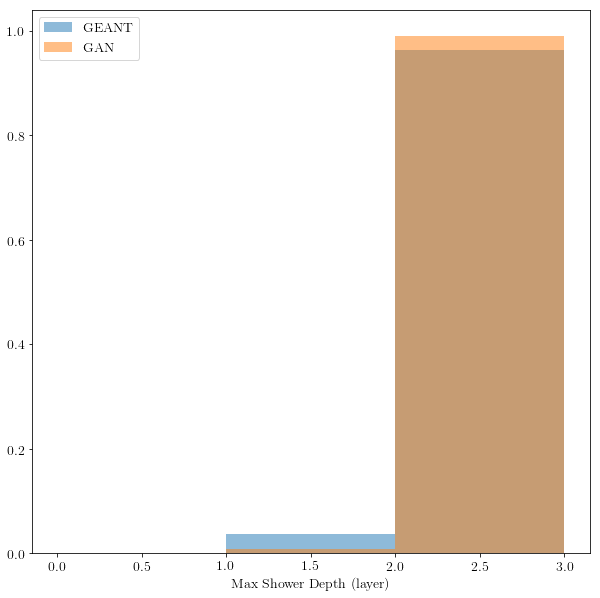

In [194]:
bins = [0, 1, 2, 3]
plt.figure(figsize=(10, 10))
_ = plt.hist(depth_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(depth_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Max Shower Depth (layer)')

In [195]:
etot_orig = total_energy(d)
etot_gen = total_energy(dgen)

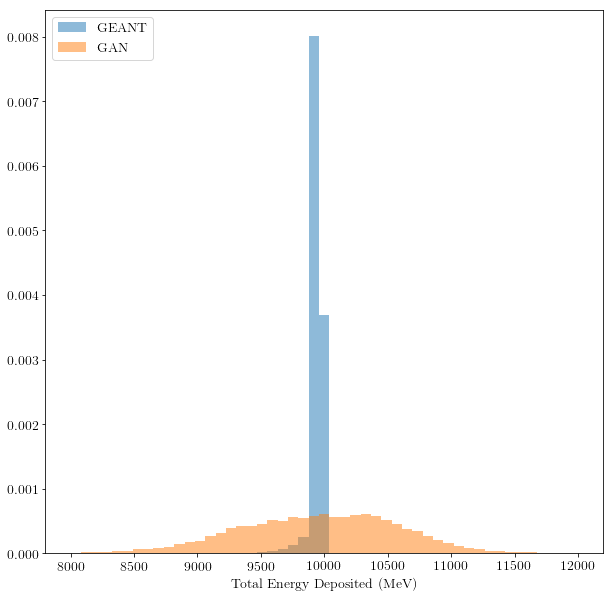

In [196]:
bins = np.linspace(8000, 12000, 50)
plt.figure(figsize=(10, 10))
_ = plt.hist(etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True',
             label='GEANT')
_ = plt.hist(etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True',
             label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Total Energy Deposited (MeV)')

In [197]:
e2_orig = energy('2', d)
e2_gen = energy('2', dgen) 
e1_orig = energy('1', d)
e1_gen = energy('1', dgen) 
e0_orig = energy('0', d)
e0_gen = energy('0', dgen)

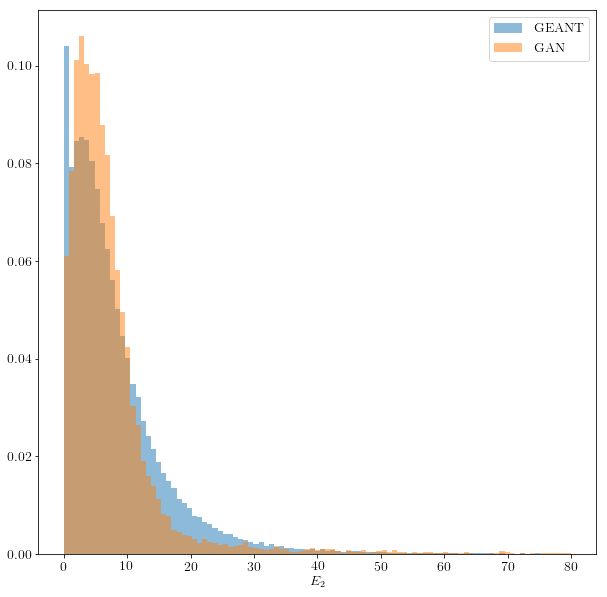

In [198]:
bins = np.linspace(0, 80, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e2_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel(r'$E_2$')

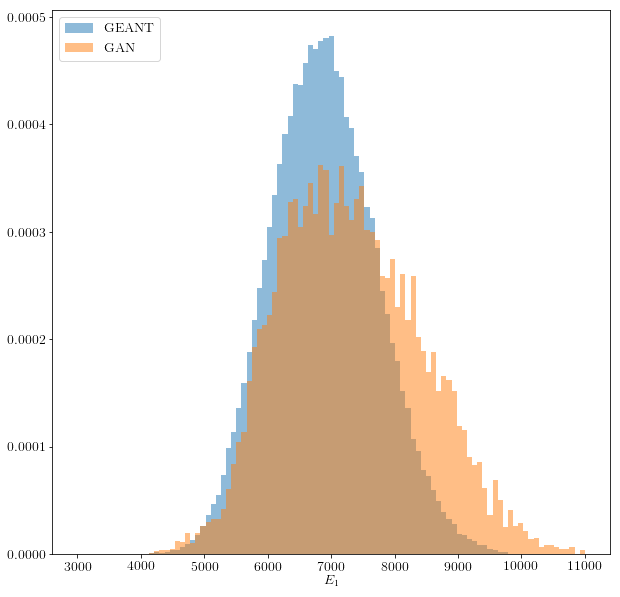

In [199]:
bins = np.linspace(3000, 11000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e1_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel(r'$E_1$')

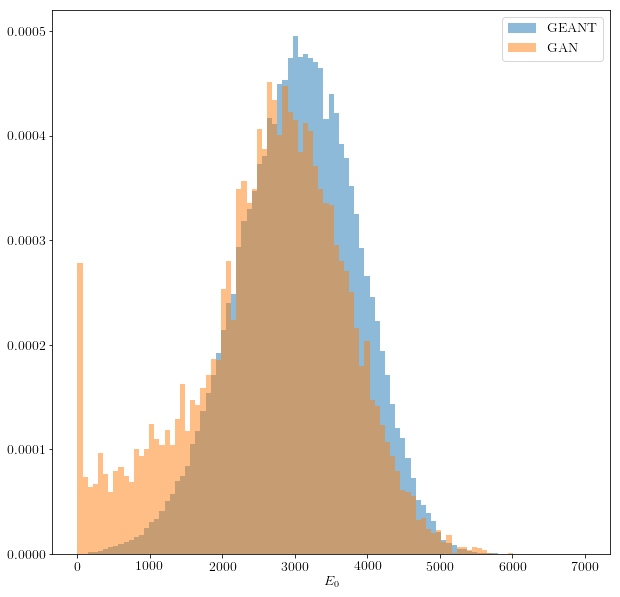

In [200]:
bins = np.linspace(0, 7000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e0_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel(r'$E_0$')

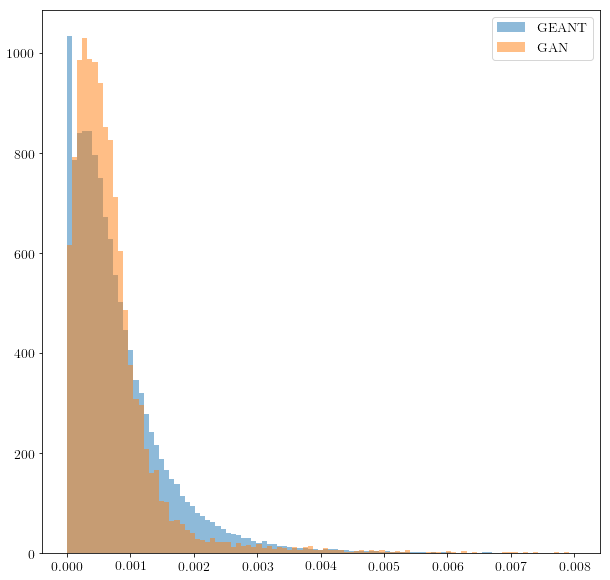

In [201]:
bins = np.linspace(0, 0.008, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e2_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

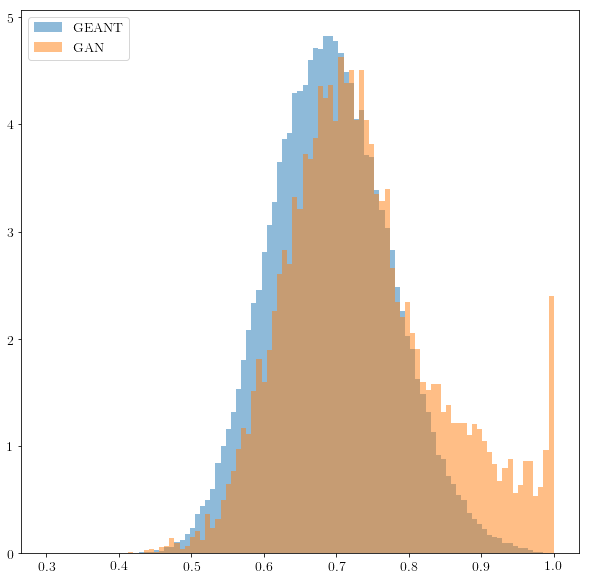

In [202]:
bins = np.linspace(0.3, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e1_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

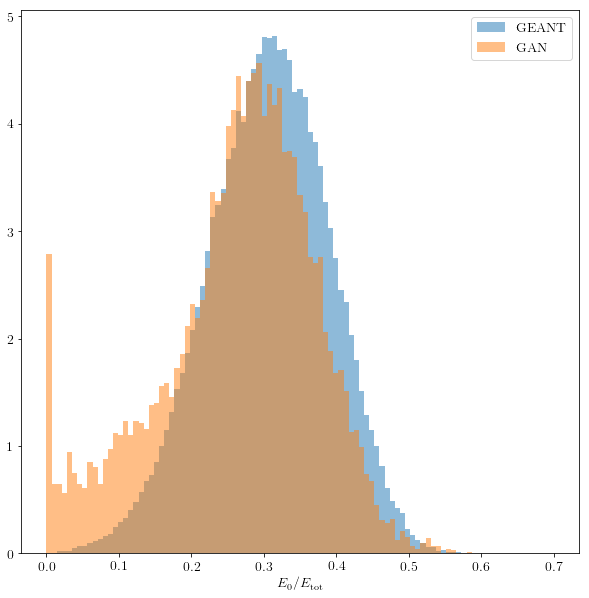

In [203]:
bins = np.linspace(0, 0.7, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e0_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel(r'$E_0 / E_{\mathrm{tot}}$')

In [204]:
lateral_depth_orig = lateral_depth(d)
lateral_depth_gen = lateral_depth(dgen)

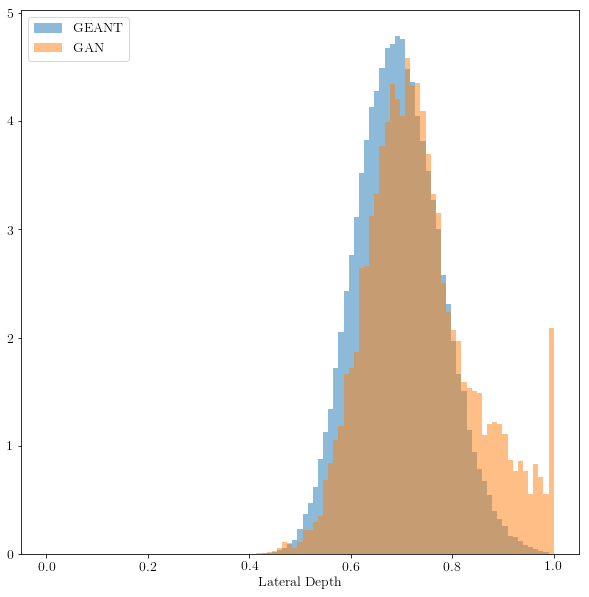

In [205]:
bins = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Lateral Depth')
# / E_tot

In [206]:
lateral_depth2_orig = lateral_depth2(d)
lateral_depth2_gen = lateral_depth2(dgen)

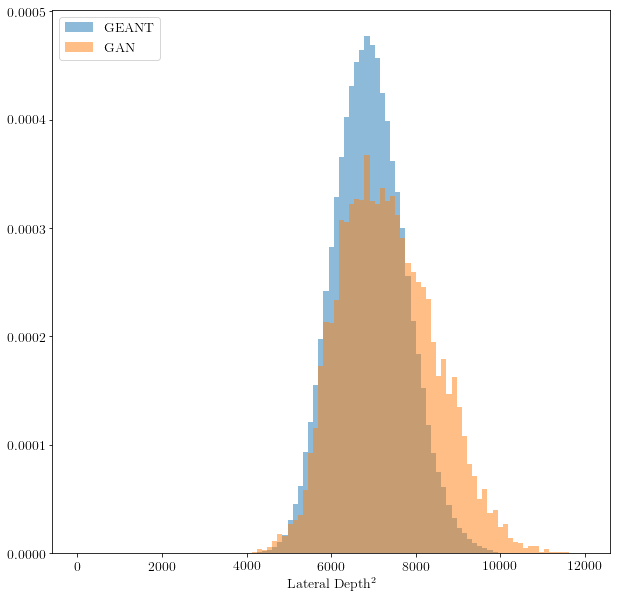

In [207]:
bins = np.linspace(0, 12000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth2_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth2_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel(r'Lateral Depth$^2$')

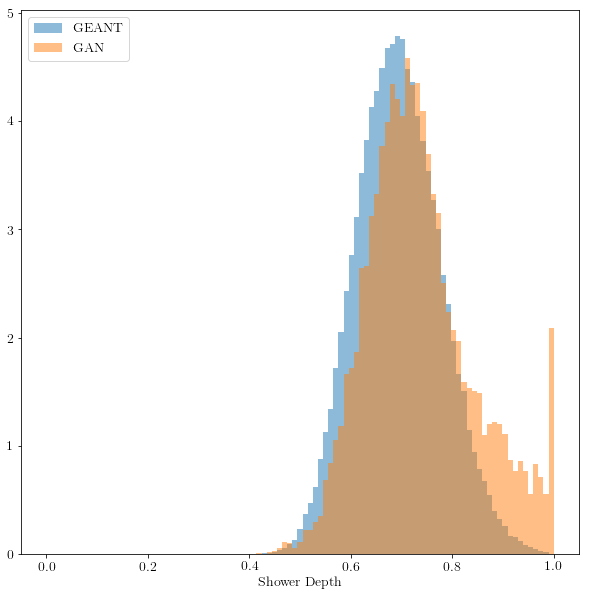

In [208]:
# shower depth
bins = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Shower Depth')

In [209]:
shower_depth_width_orig = shower_depth_width(
    lateral_depth_orig, lateral_depth2_orig, etot_orig)
shower_depth_width_gen = shower_depth_width(
    lateral_depth_gen, lateral_depth2_gen, etot_gen)

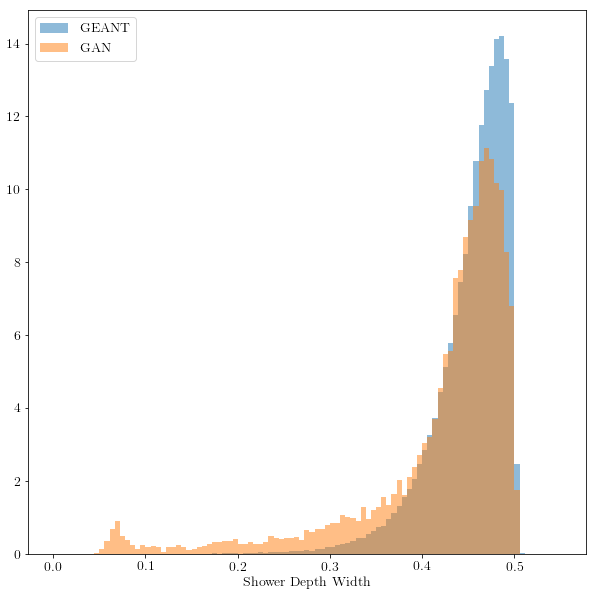

In [210]:
# shower depth width
bins = np.linspace(0, 0.55, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(shower_depth_width_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(shower_depth_width_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Shower Depth Width')

In [211]:
lateral_width0_orig = layer_lateral_width('0', d)
lateral_width1_orig = layer_lateral_width('1', d)
lateral_width2_orig = layer_lateral_width('2', d)
lateral_width0_gen = layer_lateral_width('0', dgen)
lateral_width1_gen = layer_lateral_width('1', dgen)
lateral_width2_gen = layer_lateral_width('2', dgen)

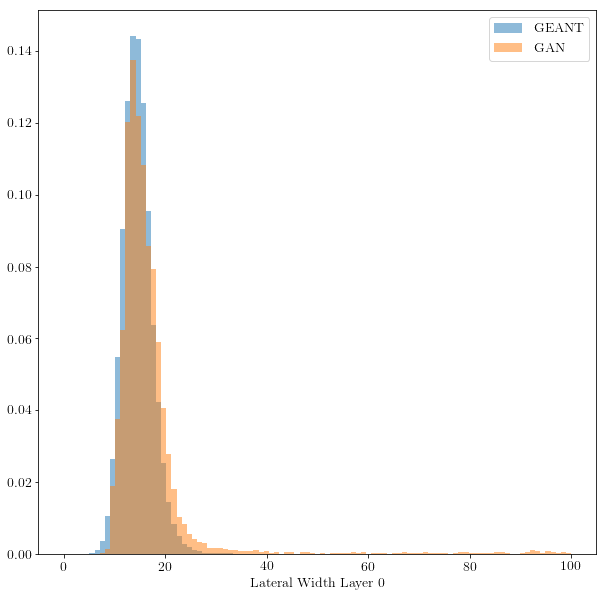

In [212]:
# layer 0 lateral width
bins = np.linspace(0, 100, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width0_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width0_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel('Lateral Width Layer 0')

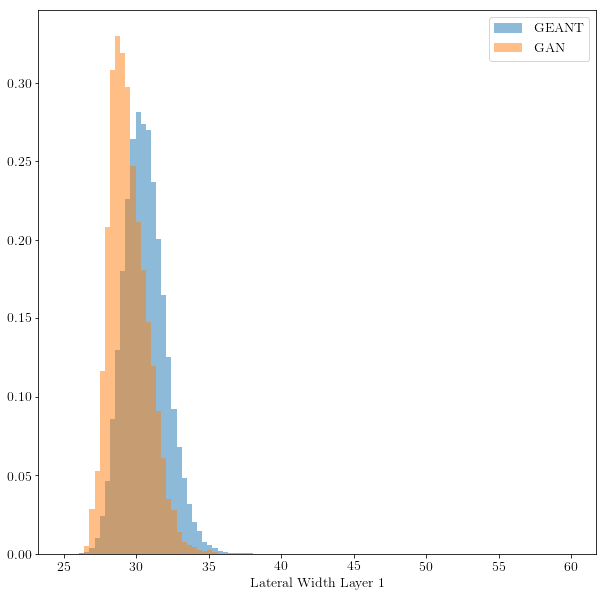

In [213]:
# layer 1 lateral width
bins = np.linspace(25, 60, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width1_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width1_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel('Lateral Width Layer 1')

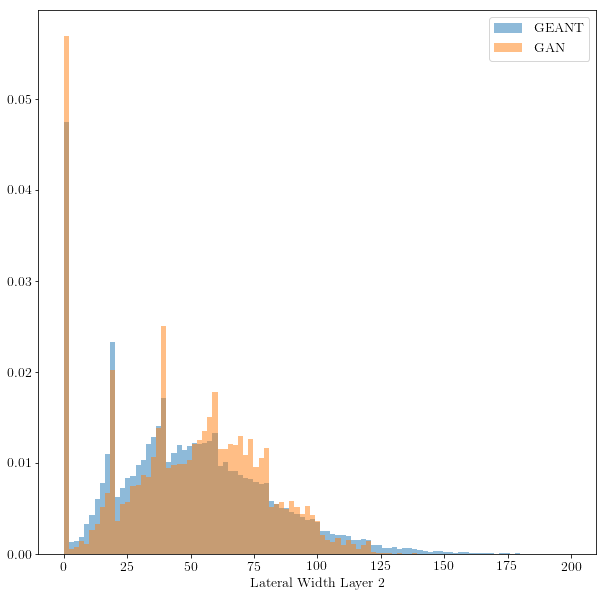

In [214]:
# layer 2 lateral width
bins = np.linspace(0, 200, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width2_orig[np.isfinite(lateral_width2_orig)] , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width2_gen[np.isfinite(lateral_width2_gen)], bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')
plt.xlabel('Lateral Width Layer 2')

# Classification

In [215]:
d = h5py.File('../data/electrons-10GeV-incidence-perp.hdf5', 'r')
first = d['layer_0'][:]
second = d['layer_1'][:]
third = d['layer_2'][:]
first /=(500)
second /=(500)
third/=(500)
yhat_real_electrons = discriminator.predict([
    np.expand_dims(first[:], -1),
    np.expand_dims(second[:], -1),
    np.expand_dims(third[:], -1)],
      verbose=True,
      batch_size=200)

100000/100000 [==============================] - 130s     

In [216]:
d_y = h5py.File('../data/gamma-10GeV-incidence-perp.hdf5', 'r')
first_y = d_y['layer_0'][:]
second_y = d_y['layer_1'][:]
third_y = d_y['layer_2'][:]
first_y /=(500)
second_y /=(500)
third_y/=(500)
yhat_real_photons = discriminator.predict([
    np.expand_dims(first_y[:], -1),
    np.expand_dims(second_y[:], -1),
    np.expand_dims(third_y[:], -1)],
      verbose=True,
      batch_size=200)

100000/100000 [==============================] - 106s     

In [217]:
yhat_fake = discriminator.predict(
    [gen_images[0], gen_images[1], gen_images[2]],
      verbose=True,
      batch_size=200)

10000/10000 [==============================] - 11s     

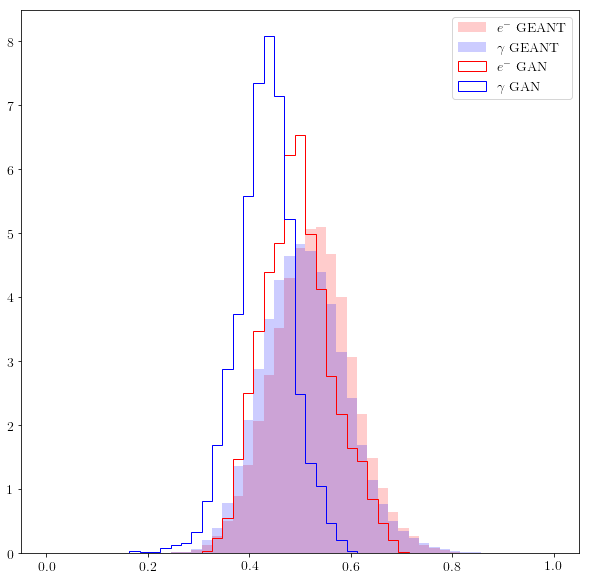

In [218]:
plt.figure(figsize=(10, 10))
bins = np.linspace(0, 1, 50)
_ = plt.hist(yhat_real_electrons[0], bins=bins, linestyle='dashed', normed=True,# edgecolor='red',
             histtype='stepfilled', label=r'$e^-$ GEANT', fc=(1, 0, 0, 0.2)) # fake vs real
_ = plt.hist(yhat_real_photons[0], bins=bins, linestyle='dashed', normed=True,# edgecolor='blue',
             histtype='stepfilled', label=r'$\gamma$ GEANT', fc=(0, 0, 1, 0.2)) # fake vs real
_ = plt.hist(yhat_fake[0][sampled_labels == 0], bins=bins, normed=True,
             histtype='step', label=r'$e^-$ GAN', color='red') # fake vs real
_ = plt.hist(yhat_fake[0][sampled_labels == 1], bins=bins, normed=True,
             histtype='step', label=r'$\gamma$ GAN', color='blue') # fake vs real
plt.legend()

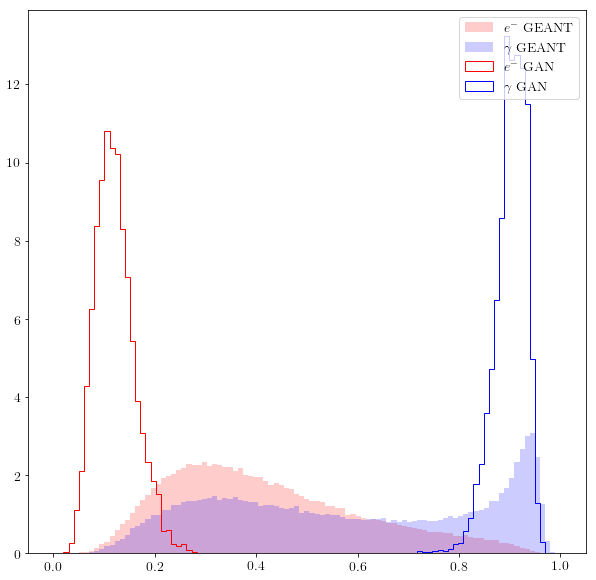

In [219]:
plt.figure(figsize=(10, 10))
bins = np.linspace(0, 1, 100)
_ = plt.hist(yhat_real_electrons[1], bins=bins, linestyle='dashed', normed=True,# edgecolor='red',
             histtype='stepfilled', label=r'$e^-$ GEANT', fc=(1, 0, 0, 0.2)) 
_ = plt.hist(yhat_real_photons[1], bins=bins, linestyle='dashed', normed=True,# edgecolor='blue',
             histtype='stepfilled', label=r'$\gamma$ GEANT', fc=(0, 0, 1, 0.2)) 
_ = plt.hist(yhat_fake[1][sampled_labels == 0], bins=bins, normed=True,
             histtype='step', label=r'$e^-$ GAN', color='red') 
_ = plt.hist(yhat_fake[1][sampled_labels == 1], bins=bins, normed=True,
             histtype='step', label=r'$\gamma$ GAN', color='blue') 
plt.legend()